# House Price

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
%matplotlib inline

/Users/kevintaing/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [3]:
# reading in data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### Column names

In [4]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Linear regression on sales price and Lotarea

In [5]:
lotArea = train_data.iloc[:, [0,4]] # this will be our independent variable
salePrice = train_data.iloc[:, [0, -1]] # this will be our dependent variable

In [6]:
# linear regression
regressor = LinearRegression()
regressor.fit(lotArea, salePrice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

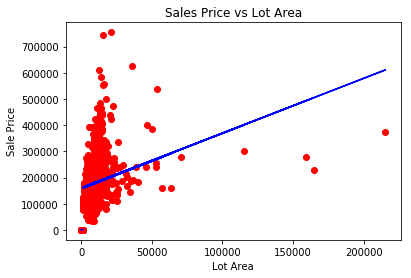

In [7]:
# visualize
plt.scatter(lotArea, salePrice, color='red') # plot all the points
plt.plot(lotArea, regressor.predict(lotArea), color='blue') # plot the regression line
plt.title('Sales Price vs Lot Area')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')
plt.show()

# Year built vs Sales prices

In [8]:
yearBuilt = train_data.iloc[:, [0,19]]
salePrice = train_data.iloc[:, [0, -1]]

In [9]:
# will determine how old house is by currentYear(2017) - yearBuilt
houseAge = []
yearBuiltMatrix = yearBuilt.as_matrix()
for row in range(len(yearBuiltMatrix)):
    houseAge.append([yearBuiltMatrix[row,0],2017 - yearBuiltMatrix[row,1]])

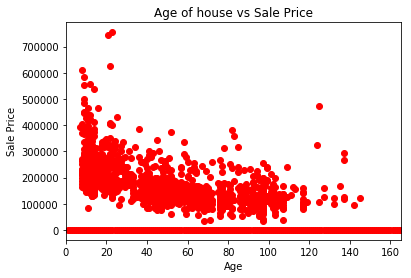

In [10]:
# visualize
plt.scatter(houseAge, salePrice, color='red')
plt.title('Age of house vs Sale Price')
plt.xlabel('Age')
plt.ylabel('Sale Price')
plt.xlim([0, 165])
plt.show()

# Multiple Regression

### Data preprocessing

In [11]:
# break train_data into dependent and independent columns
ind_dframe = train_data.iloc[:, 1:-1] # all the columns except sale price and ID
dep_dframe = train_data.iloc[:, -1] # sale price

# skew data
numeric_features = ind_dframe.dtypes[ind_dframe.dtypes != "object"].index

skewed_features = ind_dframe[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

ind_dframe[skewed_features] = np.log1p(ind_dframe[skewed_features])
dep_dframe = np.log1p(dep_dframe)

# get dummies
ind_dframe = pd.get_dummies(ind_dframe)

# replave NA with the column mean
# NOTE: Might need to replace NA case-by-case
ind_dframe = ind_dframe.fillna(ind_dframe.mean())

# values of the data frame
ind = ind_dframe.values
dep = dep_dframe.values

# split into test and train sets
ind_train, ind_test, dep_train, dep_test = train_test_split(ind, dep, test_size = 0.3, random_state = 0)

### Model

In [12]:
regressor = LinearRegression()
regressor.fit(ind_train, dep_train)

sale_predictions = regressor.predict(ind_test)

### Prediction

Now that the model has been fitted with out data we will calculate the average difference between the train and test data.

In [13]:
data_difference = []

for index in range(len(dep_test)):
    data_difference.append(abs(dep_test[index] - sale_predictions[index]))


* Max difference

In [14]:
np.amax(data_difference)

5.2421353544323122

* Min difference

In [15]:
np.amin(data_difference)

0.00077992713137930991

* Average

In [16]:
np.mean(data_difference)

0.11847508061104556

### Findings

In [17]:
# getting all coefficients
coef = pd.Series(regressor.coef_, index = ind_dframe.columns)

# gettings signifigant coefficients
sig_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

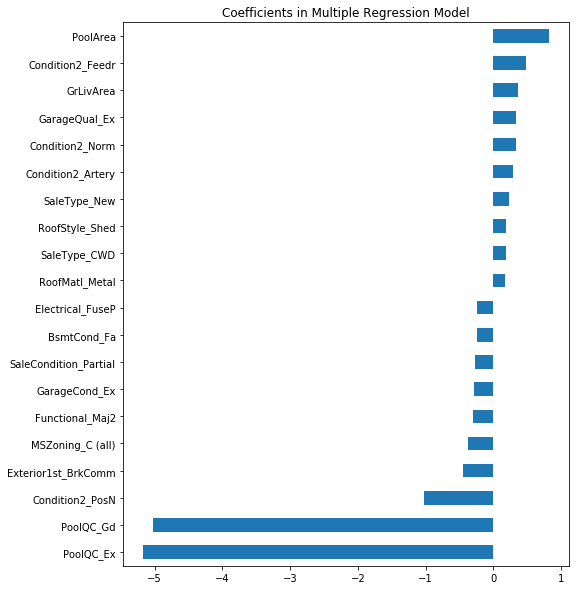

In [18]:
# graphing signifigant coefficients
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
sig_coef.plot(kind = "barh")
plt.title("Coefficients in Multiple Regression Model")

# Lasso Regression

### Data Preprocessing

In [19]:
# reading in data
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117e5e550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117fb2f98>]], dtype=object)

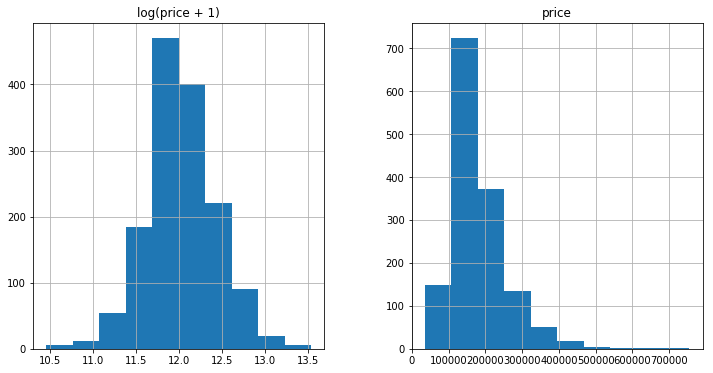

In [20]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [21]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
#all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
#all_data = all_data.fillna(all_data.mean())

##### Filling NA and missing values

In [22]:
all_data['PoolQC'] = all_data['PoolQC'].fillna("None")

all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

all_data['Alley'] = all_data['Alley'].fillna('None')

all_data['Fence'] = all_data['Fence'].fillna('None')

all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#all_data = all_data.fillna(all_data.mean())

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
all_data = pd.get_dummies(all_data)

In [23]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Model

In [24]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12346441612392796

In [25]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 117 variables


In [26]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

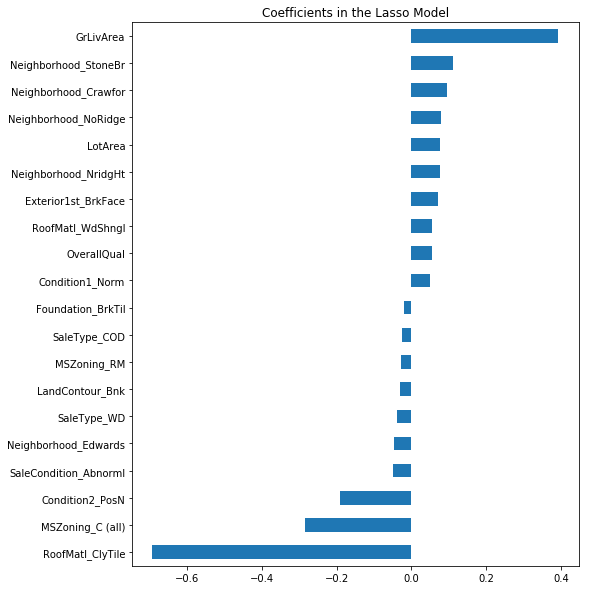

In [27]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

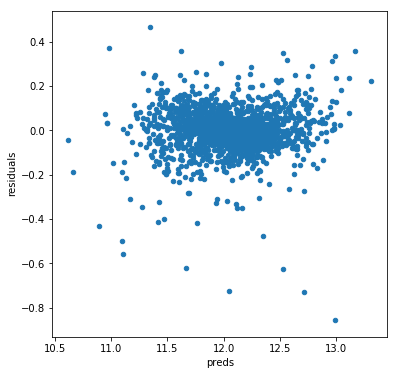

In [28]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Predictions

In [29]:
model_lasso.score(X_train, y)

0.92815451015137795

# XG Boost Model

In [30]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

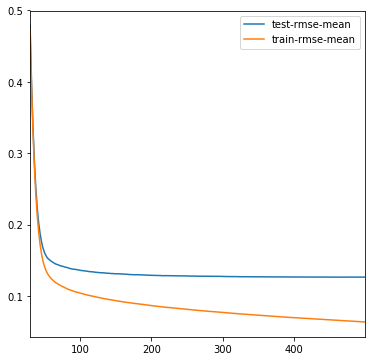

In [31]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()